In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
tran = transforms.Compose([transforms.ToTensor()])

In [4]:
train_dataset = datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=tran)

test_dataset = datasets.MNIST(
    './data',
    train=False,
    download=True,
    transform=tran
)

In [5]:
BATCH_SIZE = 64         # number of data points in each batch
N_EPOCHS = 10           # times to run the model on complete data
INPUT_DIM = 28 * 28     # size of each input
HIDDEN_DIM = 256        # hidden dimension   50
LATENT_DIM = 75         # latent vector dimension   8
N_CLASSES = 10          # number of classes in the data
lr = 1e-3               # learning rate
BETA = 0.5

In [6]:
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [7]:
def idx2onehot(idx, n=N_CLASSES):

    assert idx.shape[1] == 1
    assert torch.max(idx).item() < n

    onehot = torch.zeros(idx.size(0), n)
    onehot.scatter_(1, idx.data, 1)

    return onehot

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, condition_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim + condition_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim, latent_dim)
        self.act = nn.LeakyReLU(0.3)
    def forward(self, x):
        hidden = self.act(self.linear(x))
        mean = self.act(self.mu(hidden))
        log_var = self.act(self.var(hidden))
        return mean, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, n_classes):
        super().__init__()
        self.latent_to_hidden = nn.Linear(latent_dim + n_classes, hidden_dim)
        self.hidden_to_out = nn.Linear(hidden_dim, output_dim)
        self.act = nn.LeakyReLU(0.3)
    def forward(self, x):
        x = self.act(self.latent_to_hidden(x))
        generated_x = torch.sigmoid(self.hidden_to_out(x))
        return generated_x
    
class CVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, n_classes):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim, n_classes)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim, n_classes)
    def forward(self, x, y):
        x = torch.cat((x, y), dim=1)
        z_mu, z_var = self.encoder(x)
        std = torch.exp(z_var / 2)
        eps = torch.randn_like(std)
        x_sample = eps.mul(std).add_(z_mu)
        z = torch.cat((x_sample, y), dim=1)
        generated_x = self.decoder(z)
        return generated_x, z_mu, z_var

In [9]:
#model
model = CVAE(INPUT_DIM, HIDDEN_DIM, LATENT_DIM, N_CLASSES)

#optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [10]:
def calculate_loss(x, reconstructed_x, mean, log_var):
    # reconstruction loss
    RCL = F.binary_cross_entropy(reconstructed_x, x, size_average=False)
    # kl divergence loss
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return (1 - BETA)* RCL + BETA*KLD

In [11]:
def train():
    # set the train mode
    model.train()
    # loss of the epoch
    train_loss = 0

    for i, (x, y) in enumerate(train_iterator):
        x = x.view(-1, 28 * 28)
        y = idx2onehot(y.view(-1, 1))
        optimizer.zero_grad()
        reconstructed_x, z_mu, z_var = model(x, y)
        loss = calculate_loss(x, reconstructed_x, z_mu, z_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    return train_loss

In [12]:
def test():
    # set the evaluation mode
    model.eval()
    # test loss for the data
    test_loss = 0
    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for i, (x, y) in enumerate(test_iterator):
            x = x.view(-1, 28 * 28)
            y = idx2onehot(y.view(-1, 1))
            reconstructed_x, z_mu, z_var = model(x, y)
            loss = calculate_loss(x, reconstructed_x, z_mu, z_var)
            test_loss += loss.item()
    return test_loss

In [13]:
best_test_loss = 1000
for e in range(N_EPOCHS):

    train_loss = train()
    test_loss = test()

    train_loss /= len(train_dataset)
    test_loss /= len(test_dataset)

    print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')

    if best_test_loss > test_loss:
        best_test_loss = test_loss
        patience_counter = 1
    else:
        patience_counter += 1

    if patience_counter > 5:
        break

C:\SongyanHou\Programs\Anaconda\envs\gpflow2\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0, Train Loss: 80.50, Test Loss: 65.16
Epoch 1, Train Loss: 62.22, Test Loss: 59.45
Epoch 2, Train Loss: 58.54, Test Loss: 56.94
Epoch 3, Train Loss: 56.71, Test Loss: 55.61
Epoch 4, Train Loss: 55.53, Test Loss: 54.67
Epoch 5, Train Loss: 54.70, Test Loss: 53.88
Epoch 6, Train Loss: 54.09, Test Loss: 53.60
Epoch 7, Train Loss: 53.64, Test Loss: 52.99
Epoch 8, Train Loss: 53.28, Test Loss: 52.72
Epoch 9, Train Loss: 52.99, Test Loss: 52.43


Generating a 6


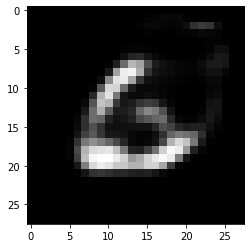

In [19]:
# create a random latent vector
z = torch.randn(1, LATENT_DIM).to(device)

# pick randomly 1 class, for which we want to generate the data
y = torch.randint(0, N_CLASSES, (1, 1)).to(dtype=torch.long)
print(f'Generating a {y.item()}')

y = idx2onehot(y).to(device, dtype=z.dtype)
z = torch.cat((z, y), dim=1)

reconstructed_img = model.decoder(z)
img = reconstructed_img.view(28, 28).data

plt.figure()
plt.imshow(img, cmap='gray')
plt.show()